# DONE:

- x include non-Metaphor data and label

- repeat experiments after sampling original sentences, not random sampling

- fix the damn indentation on the accuracy

- Try freezing some layers. Hopefully reduces training time (significantly)

- FIXING BERT TOKENIZER TO REDEWIEDERGABE!!!

- make use of cuda or mps nicer

- increase freeze rate (Dropped performance slightly)

- add additional dropout layer (not really sure if it helped)

# NOW:

- include loss and score plots

# TODO:
    
- include F1-score in evaluation

- x test F1-score loss function
    - https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook
    - not avaiable for mps yet!


In [1]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import os
import re

np.random.seed(3093453)
sns.set(context="talk", style="darkgrid")

In [8]:
cwd = os.getcwd()
folders = ["unclean+translated-data", "clean+translated-data"]
file = "total.csv"

dfs = []

for folder in folders:
    path = "/".join( (cwd, folder, file) )
    df = pd.read_csv(path, index_col=0)
    dfs.append(df)

unclean_df, clean_df = dfs
unclean_df

,index,Textstelle,Metapher,Metaphernkandidat,Nein,Metapher?,Fokus,Rahmen,Annotator,orig,lang,sentence_id
0,0,"""Der politische Körper verwendet in beiden Fä...",3,1,0,Metapher,"['Zähnen und Krallen', 'Zähnen und Krallen', n...","['der politische Körper', 'der politische Körp...","['B', 'K', 'A', 'GoldStandard']","""Der politische Körper verwendet in beiden Fä...",de,0
1,1,"""Immer noch wird durch die protestantische Le...",0,4,0,Metaphernkandidat,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","['B', 'K', 'A', 'GoldStandard']","""Immer noch wird durch die protestantische Le...",de,1
2,2,"""Kein Zweifel"", schreibt Alb. Schaeffle 1), v...",0,4,0,Metaphernkandidat,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","['B', 'K', 'A', 'GoldStandard']","""Kein Zweifel"", schreibt Alb. Schaeffle 1), v...",de,2
3,3,"""Mit je weiterem Blick wir die Stoffwelt zu ü...",1,3,0,Metaphernkandidat,"[nan, 'Stoffwelt, verzwergt und entkleidet', n...","[nan, 'unser praktisches Ideal', nan, nan]","['B', 'K', 'A', 'GoldStandard']","""Mit je weiterem Blick wir die Stoffwelt zu ü...",de,3
4,4,"""Solange das Menschengeschlecht seinen Zerstö...",0,4,0,Metaphernkandidat,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","['B', 'K', 'A', 'GoldStandard']","""Solange das Menschengeschlecht seinen Zerstö...",de,4
...,...,...,...,...,...,...,...,...,...,...,...,...
5558,3960,In der Zeit des Humanismus und der Reformation...,0,0,1,Nein,NaN,NaN,X,In der Zeit des Humanismus und der Reformation...,de,4759
5559,3961,Den Mittelpunkt der Bildung stellten die alten...,0,0,1,Nein,NaN,NaN,X,Den Mittelpunkt der Bildung stellten die alten...,de,4760
5560,3962,Jahrhunderts hat eine beständige Differenzieru...,0,0,1,Nein,NaN,NaN,X,Jahrhunderts hat eine beständige Differenzieru...,de,4761
5561,3963,Die Pädagogik der Neuzeit scheint davon wenig ...,0,0,1,Nein,NaN,NaN,X,Die Pädagogik der Neuzeit scheint davon wenig ...,de,4762


In [9]:
clean_df

,index,Textstelle,Metapher,Metaphernkandidat,Nein,Metapher?,Fokus,Rahmen,Annotator,orig,lang,sentence_id
0,0,Der politische Körper verwendet in beiden Fäll...,3,1,0,Metapher,"['Zähnen und Krallen', 'Zähnen und Krallen', n...","['der politische Körper', 'der politische Körp...","['B', 'K', 'A', 'GoldStandard']","""Der politische Körper verwendet in beiden Fä...",de,0
1,1,Immer noch wird durch die protestantische Lehr...,0,4,0,Metaphernkandidat,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","['B', 'K', 'A', 'GoldStandard']","""Immer noch wird durch die protestantische Le...",de,1
2,2,"Kein Zweifel, schreibt Alb. Schaeffle, vorauss...",0,4,0,Metaphernkandidat,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","['B', 'K', 'A', 'GoldStandard']","""Kein Zweifel"", schreibt Alb. Schaeffle 1), v...",de,2
3,3,Mit je weiterem Blick wir die Stoffwelt zu übe...,1,3,0,Metaphernkandidat,"[nan, 'Stoffwelt, verzwergt und entkleidet', n...","[nan, 'unser praktisches Ideal', nan, nan]","['B', 'K', 'A', 'GoldStandard']","""Mit je weiterem Blick wir die Stoffwelt zu ü...",de,3
4,4,Solange das Menschengeschlecht seinen Zerstöre...,0,4,0,Metaphernkandidat,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","['B', 'K', 'A', 'GoldStandard']","""Solange das Menschengeschlecht seinen Zerstö...",de,4
...,...,...,...,...,...,...,...,...,...,...,...,...
3960,3960,In der Zeit des Humanismus und der Reformation...,0,0,1,Nein,NaN,NaN,X,In der Zeit des Humanismus und der Reformation...,de,4759
3961,3961,Den Mittelpunkt der Bildung stellten die alten...,0,0,1,Nein,NaN,NaN,X,Den Mittelpunkt der Bildung stellten die alten...,de,4760
3962,3962,Jahrhunderts hat eine beständige Differenzieru...,0,0,1,Nein,NaN,NaN,X,Jahrhunderts hat eine beständige Differenzieru...,de,4761
3963,3963,Die Pädagogik der Neuzeit scheint davon wenig ...,0,0,1,Nein,NaN,NaN,X,Die Pädagogik der Neuzeit scheint davon wenig ...,de,4762


## Sentence ID

We need to do this to make sure we dont have a german sentence in the train data
... and a english version in the test data, which skewes the results

(Essentially the model would just memorize seen points, rather than learn what a metaphor is)



# BERT CLASSIFIER

https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

## DATASET

In [10]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("redewiedergabe/bert-base-historical-german-rw-cased")

# Later: non-Metaphor: 0, Candidate: 1, Metaphor: 2
labs = ["Metapher", "Metaphernkandidat", "Nein"]

labels = dict(zip(labs, range(3)))
labels

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        # gold and silver labels
        
        self.labels = [labels[label] for label in df["Metapher?"]]
        #self.labels = df[labs].to_numpy().argmax(axis=1)
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['Textstelle']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

## Train test split:

create a original-sentence id

We need to do this to make sure we dont have a german sentence in the train data and a english version in the test 
data, which skewes the results

(Essentially the model would just memorize seen points, rather than learn what a metaphor is)

In [12]:
unique_sentences = df.orig.unique()

sentence_id = [np.where(sentence == unique_sentences)[0].item() for sentence in df.orig]
df["sentence_id"] = sentence_id

unique_sentence_ids = df.sentence_id.unique()
n_unique_sentences = len(unique_sentence_ids)


# randomize data before splitting
sample = np.random.choice(unique_sentence_ids, n_unique_sentences, replace=False)

# train/val/test split of original sentences
train_sentence_ids,val_sentence_ids,test_sentence_ids = np.split(sample,
                                                                 [int(.8*n_unique_sentences),
                                                                  int(.9*n_unique_sentences)])

print(len(train_sentence_ids),len(val_sentence_ids), len(test_sentence_ids))

# train/val/test split rows
clean_df_train = clean_df[np.isin(clean_df.sentence_id, train_sentence_ids)]
clean_df_val   = clean_df[np.isin(clean_df.sentence_id, val_sentence_ids  )]
clean_df_test  = clean_df[np.isin(clean_df.sentence_id, test_sentence_ids )]

unclean_df_train = unclean_df[np.isin(unclean_df.sentence_id, train_sentence_ids)]
unclean_df_val   = unclean_df[np.isin(unclean_df.sentence_id, val_sentence_ids  )]
unclean_df_test  = unclean_df[np.isin(unclean_df.sentence_id, test_sentence_ids )]



print(len(clean_df_train),len(clean_df_val), len(clean_df_test))

print(len(unclean_df_train),len(unclean_df_val), len(unclean_df_test))

3811 476 477
6391 776 793
4456 551 556


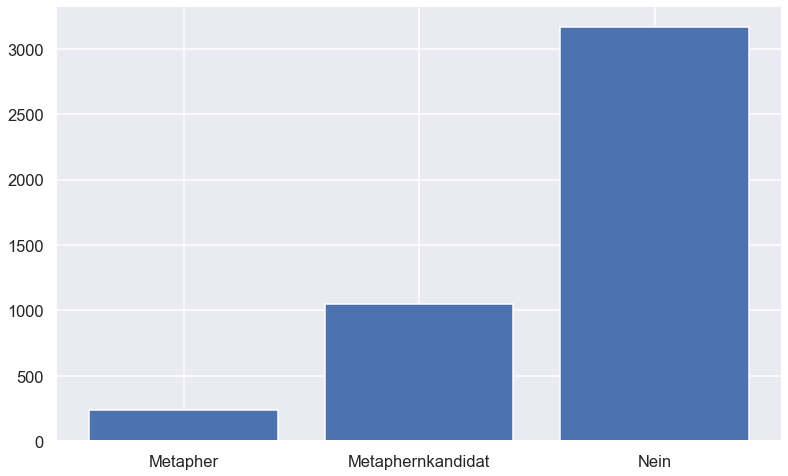

In [13]:
vc = pd.Series([labels[label] for label in unclean_df_train["Metapher?"]]).value_counts()

fig, ax = plt.subplots(figsize=(13, 8))
plt.bar(vc.index, vc)
plt.xticks(range(3),labs);

## Building a Bert Model

In [14]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5, freeze = 0.8):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained("redewiedergabe/bert-base-historical-german-rw-cased")
        
        params = self.bert.parameters()
        for i, param in enumerate(params):
            if i > 197 * freeze:
                continue
            param.requires_grad = False
            
        self.dropout1    = nn.Dropout(dropout)
        self.linear1     = nn.Linear(768, 768)
        self.activation1 = nn.ReLU(inplace=False)
        self.dropout2    = nn.Dropout(dropout)
        self.linear2     = nn.Linear(768, 3)
        self.softmax     = nn.Softmax(dim=1)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        
        dropout_output1 = self.dropout1(pooled_output)
        linear_output1 = self.linear1(dropout_output1)
        activation1 = self.activation1(linear_output1)
        
        dropout_output2 = self.dropout2(activation1)
        linear_output2 = self.linear2(dropout_output2)
        
        final_layer = self.softmax(linear_output2)

        return final_layer
    
clean_model = BertClassifier()
unclean_model = BertClassifier()

Some weights of the model checkpoint at redewiedergabe/bert-base-historical-german-rw-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at redewiedergabe/bert-base-historical-german-rw-cased were not used when initializi

In [15]:
#PyTorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)   
        inputs = inputs.softmax(dim=-1)
        
        # turn target from indices to n x 4 dummy tensor
        bs = len(targets)
        y = torch.zeros(bs,3)
        y[torch.arange(0, bs), targets.long()] = 1
        targets = y
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [16]:
from torch.optim import Adam
from tqdm.notebook import tqdm

def train(model, train_data, val_data, learning_rate, epochs):
    
    # Basic setup: data, criterion, optimizer
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)
    
    # make use of GPU acceleration if available
    if torch.backends.mps.is_available():
        use_device = "mps"
        print("Using M1 Chip! for training")

    elif torch.cuda.is_available():
        use_device = "cuda"
        print("Using Graphics Card for training")
    else:
        use_device = "cpu"
        print("Using regular CPU for training")

    device = torch.device(use_device)
    model = model.to(device)
    criterion = criterion.to(device)
    
    # plot loss
    train_losses = []
    val_losses = []
    
    # training loop
    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):
                
                # preprocessing
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)
                
                # prediction
                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                # scores
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc
                
                # actual training
                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            train_losses.append(total_loss_train / len(train_data))
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
                
                val_losses.append(total_loss_val / len(val_data))
                
            
            print(
                f'Epochs: {epoch_num + 1} \n\
                | Train Loss: \t {total_loss_train / len(train_data): .3f} \t\
                | Train Accuracy: \t {total_acc_train / len(train_data): .3f}\n\
                | Val Loss: \t {total_loss_val / len(val_data): .3f} \t\
                | Val Accuracy: \t {total_acc_val / len(val_data): .3f}')
    
    # plot losses
    plt.figure(figsize=(13, 8))
    plt.plot(train_losses, label="training loss")
    plt.plot(val_losses, label="validation loss")
    plt.legend();
    plt.show();

Using M1 Chip! for training


  0%|          | 0/557 [00:00<?, ?it/s]

Epochs: 1 
                | Train Loss: 	  0.125 	                | Train Accuracy: 	  0.651
                | Val Loss: 	  0.453 	                | Val Accuracy: 	  0.728


  0%|          | 0/557 [00:00<?, ?it/s]

Epochs: 2 
                | Train Loss: 	  0.110 	                | Train Accuracy: 	  0.711
                | Val Loss: 	  0.424 	                | Val Accuracy: 	  0.728


  0%|          | 0/557 [00:00<?, ?it/s]

Epochs: 3 
                | Train Loss: 	  0.107 	                | Train Accuracy: 	  0.711
                | Val Loss: 	  0.416 	                | Val Accuracy: 	  0.728


  0%|          | 0/557 [00:00<?, ?it/s]

Epochs: 4 
                | Train Loss: 	  0.105 	                | Train Accuracy: 	  0.711
                | Val Loss: 	  0.413 	                | Val Accuracy: 	  0.728


  0%|          | 0/557 [00:00<?, ?it/s]

Epochs: 5 
                | Train Loss: 	  0.104 	                | Train Accuracy: 	  0.711
                | Val Loss: 	  0.404 	                | Val Accuracy: 	  0.731


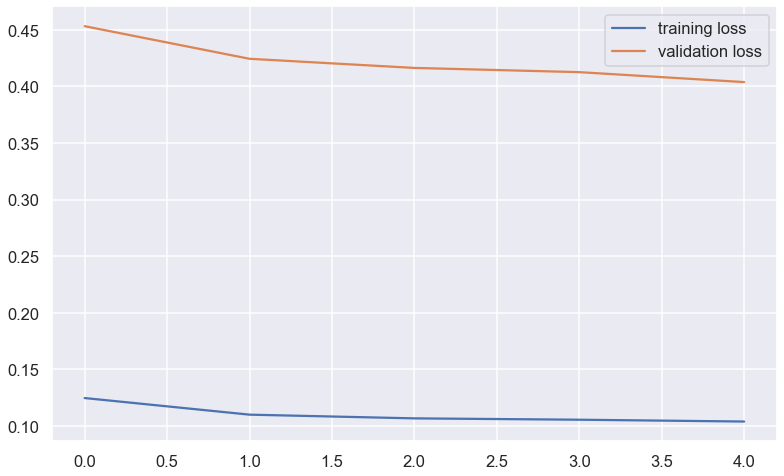

In [18]:
EPOCHS = 5
LR = 1e-6

train(unclean_model, unclean_df_train, unclean_df_val, LR, EPOCHS)

Using M1 Chip! for training


  0%|          | 0/799 [00:00<?, ?it/s]

Epochs: 1 
                | Train Loss: 	  0.133 	                | Train Accuracy: 	  0.452
                | Val Loss: 	  0.520 	                | Val Accuracy: 	  0.479


  0%|          | 0/799 [00:00<?, ?it/s]

Epochs: 2 
                | Train Loss: 	  0.126 	                | Train Accuracy: 	  0.525
                | Val Loss: 	  0.499 	                | Val Accuracy: 	  0.552


  0%|          | 0/799 [00:00<?, ?it/s]

Epochs: 3 
                | Train Loss: 	  0.121 	                | Train Accuracy: 	  0.591
                | Val Loss: 	  0.475 	                | Val Accuracy: 	  0.637


  0%|          | 0/799 [00:00<?, ?it/s]

Epochs: 4 
                | Train Loss: 	  0.112 	                | Train Accuracy: 	  0.697
                | Val Loss: 	  0.449 	                | Val Accuracy: 	  0.679


  0%|          | 0/799 [00:00<?, ?it/s]

Epochs: 5 
                | Train Loss: 	  0.107 	                | Train Accuracy: 	  0.722
                | Val Loss: 	  0.437 	                | Val Accuracy: 	  0.689


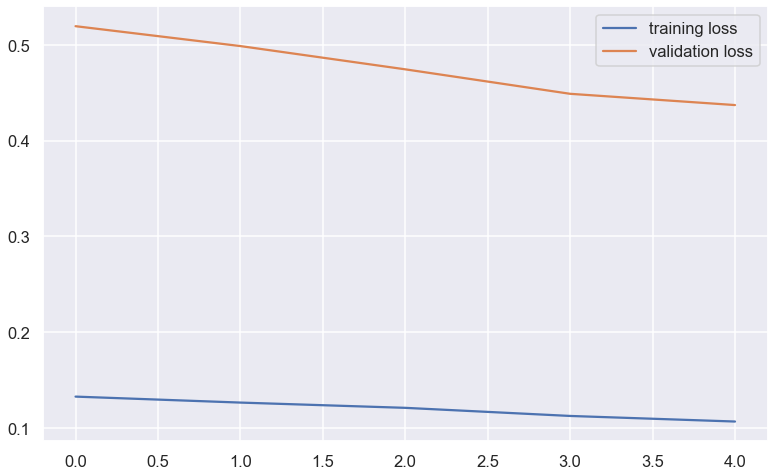

In [19]:
train(clean_model, clean_df_train, clean_df_val, LR, EPOCHS)

In [20]:
from torchsummary import summary

summary(model)

NameError: name 'model' is not defined

In [21]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    if torch.backends.mps.is_available():
        use_device = "mps"
        print("Using M1 Chip!")

    elif torch.cuda.is_available():
        use_device = "cuda"
        print("Using Graphics Card")
    else:
        use_device = "cpu"
        print("Using regular CPU")
        
    device = torch.device(use_device)
    model = model.to(use_device)



    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:
            
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            
            output = model(input_id, mask)
            
            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

NameError: name 'model' is not defined

# Error analysis

In [14]:
test = Dataset(df_test)

batch_size=5

test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS available")

y_test_prob = np.empty((len(df_test), 3), float)

test_labels = np.zeros((len(df_test)), int)

with torch.no_grad():
    
        i = 0
        for test_input, test_label in test_dataloader:
            
            test_label = test_label.to(device)
            test_labels[i*batch_size:(i+1)*batch_size] = test_label.cpu()
            
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            
            y_test_prob[i*batch_size:(i+1)*batch_size] = model(input_id, mask).cpu()
            
            i+=1

MPS available


In [15]:
y_test_true = np.zeros((len(df_test), 3))
y_test_true[np.arange(len(df_test)),test_labels] = 1
y_test_true

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [16]:
y_test_prob

array([[0.02289012, 0.95053422, 0.02657562],
       [0.01844504, 0.9540894 , 0.02746553],
       [0.0156682 , 0.94377744, 0.0405544 ],
       ...,
       [0.01551923, 0.22791025, 0.75657058],
       [0.01067548, 0.06434385, 0.92498064],
       [0.00884152, 0.07705469, 0.91410381]])

In [17]:
test_preds = y_test_prob.argmax(axis=1)
y_test_pred = np.zeros((len(df_test), 3))
y_test_pred[np.arange(len(df_test)),test_preds] = 1
y_test_pred

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

NameError: name 'y_test_true' is not defined

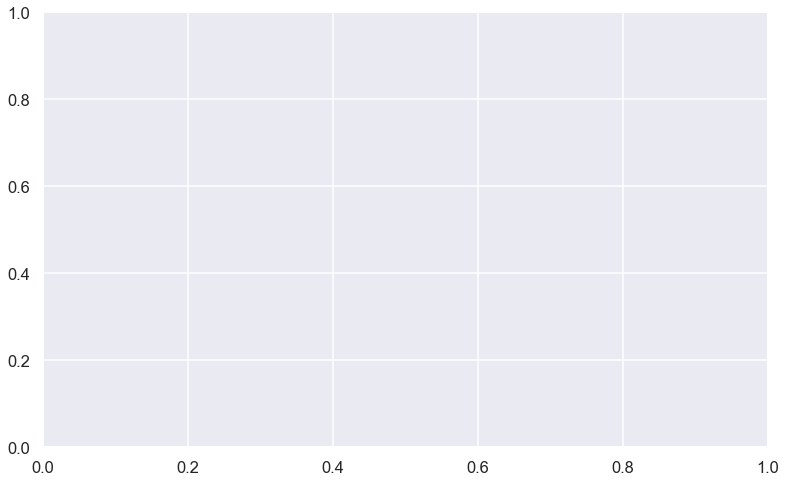

In [22]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

fig, ax = plt.subplots(figsize=(13, 8))
for i in range(3):
    prec, recall, _ = precision_recall_curve(y_test_true[:,i], y_test_prob[:,i])
    avg_prec = average_precision_score(y_test_true[:,i], y_test_prob[:,i])
    label = f"{labs[i]}:  {avg_prec:.3f}"
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax,label=label)

In [19]:
confusion_matrix = pd.crosstab(y_test_true.argmax(axis=1), y_test_prob.argmax(axis=1))
confusion_matrix.index = labs
confusion_matrix.index.name = "true label"
confusion_matrix

col_0,1,2
true label,,
Metapher,64,6
Metaphernkandidat,209,56
Nein,59,351


In [23]:
from sklearn.metrics import f1_score

print("F1 scores:\n"+"-"*23)
for i, lab in enumerate(labs):
    f1 = f1_score(y_test_true[:,i], y_test_pred[:,i], average = "binary")
    print(f"{lab:>17}: {f1:.2f}")

F1 scores:
-----------------------


NameError: name 'y_test_true' is not defined

unclean model: evaluated on unclean train
F1 scores:
-----------------------
         Metapher: 0.00
Metaphernkandidat: 0.05
             Nein: 0.83
clean model: evaluated on unclean train
F1 scores:
-----------------------
         Metapher: 0.00
Metaphernkandidat: 0.58
             Nein: 0.84
unclean model: evaluated on unclean test
F1 scores:
-----------------------
         Metapher: 0.00
Metaphernkandidat: 0.04
             Nein: 0.84
clean model: evaluated on unclean test
F1 scores:
-----------------------
         Metapher: 0.00
Metaphernkandidat: 0.62
             Nein: 0.84
unclean model: evaluated on clean train
F1 scores:
-----------------------
         Metapher: 0.00
Metaphernkandidat: 0.07
             Nein: 0.67
clean model: evaluated on clean train
F1 scores:
-----------------------
         Metapher: 0.00
Metaphernkandidat: 0.73
             Nein: 0.81
unclean model: evaluated on clean test
F1 scores:
-----------------------
         Metapher: 0.00
Metaphernkandidat: 0

[Text(0.5, 0, 'Recall'), Text(0, 0.5, 'Precision'), Text(0.5, 1.0, '')]

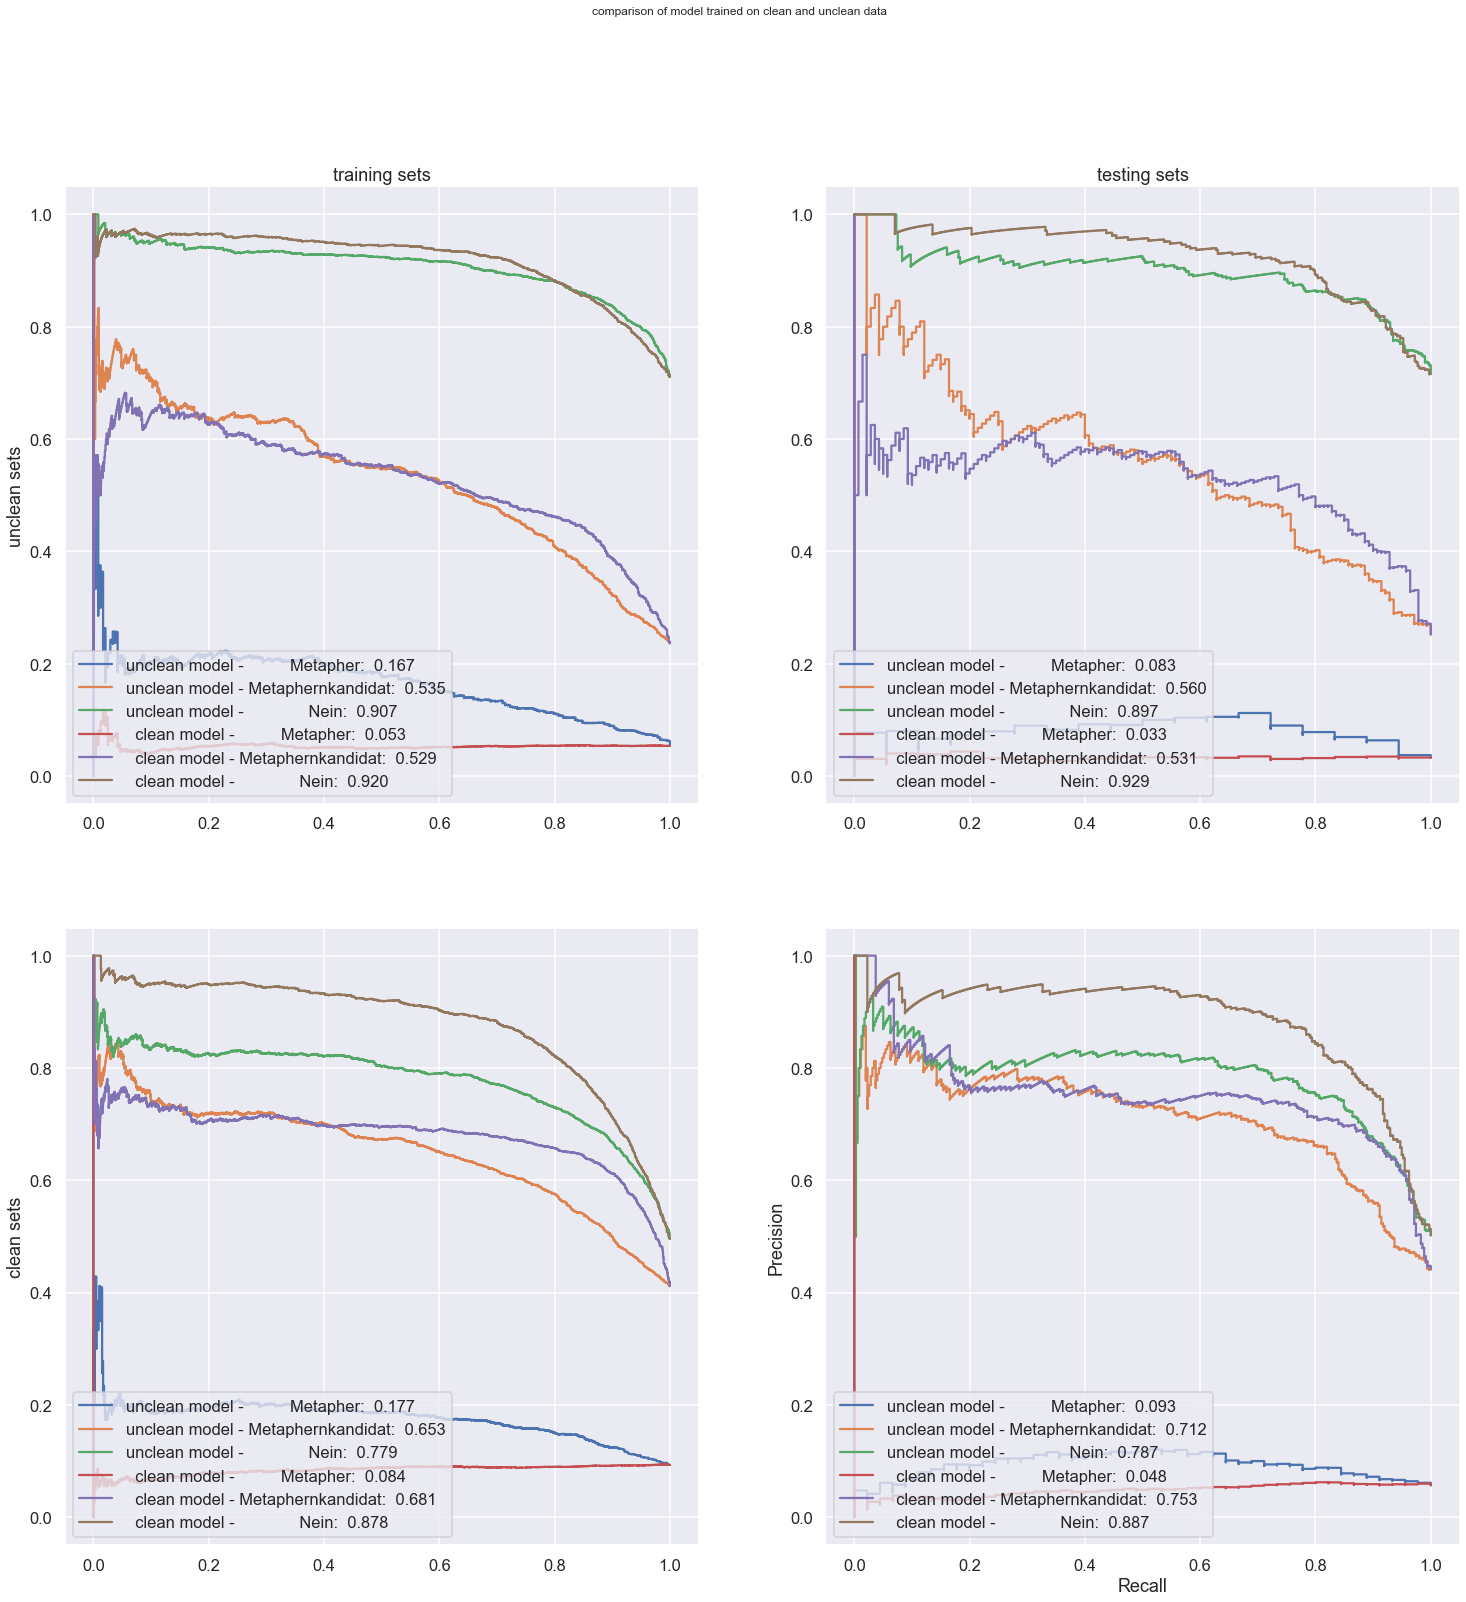

In [32]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

models = [unclean_model, clean_model]
model_names = ["unclean model", "clean model"]
datasets = [unclean_df_train, unclean_df_test,
              clean_df_train,   clean_df_test]
dataset_names = ["unclean train", "unclean test",
                 "clean train", "clean test"]

fig, ax = plt.subplots(2, 2, figsize=(25, 25))
ax[0,0].set(xlabel= "",
            ylabel= "unclean sets",
            title = "training sets")
ax[0,1].set(xlabel= "",
            ylabel= "",
            title = "testing sets")
ax[1,0].set(xlabel= "",
            ylabel= "clean sets",
            title = "")

ax[1,1].set(xlabel= "Recall",
            ylabel= "Precision",
            title = "")

fig.suptitle("comparison of model trained on clean and unclean data")

for ii, (dataset, dataset_name) in enumerate(zip(datasets, dataset_names)):
    for jj, (model, model_name) in enumerate(zip(models, model_names)):
        
        data = Dataset(dataset)

        batch_size=5

        dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size)

        if torch.backends.mps.is_available():
            device = torch.device("mps")
            #print("MPS available")

        y_test_prob = np.empty((len(dataset), 3), float)

        test_labels = np.zeros((len(dataset)), int)

        with torch.no_grad():

                i = 0
                for test_input, test_label in dataloader:

                    test_label = test_label.to(device)
                    test_labels[i*batch_size:(i+1)*batch_size] = test_label.cpu()

                    mask = test_input['attention_mask'].to(device)
                    input_id = test_input['input_ids'].squeeze(1).to(device)

                    y_test_prob[i*batch_size:(i+1)*batch_size] = model(input_id, mask).cpu()

                    i+=1

        # calculate metrics
        y_test_true = np.zeros((len(dataset), 3))
        y_test_true[np.arange(len(dataset)),test_labels] = 1

        test_preds = y_test_prob.argmax(axis=1)
        y_test_pred = np.zeros((len(dataset), 3))
        y_test_pred[np.arange(len(dataset)),test_preds] = 1
        
        
        j = ii // 2
        k = ii % 2
        for i in range(3):
            prec, recall, _ = precision_recall_curve(y_test_true[:,i], y_test_prob[:,i])
            avg_prec = average_precision_score(y_test_true[:,i], y_test_prob[:,i])
            label = f"{model_name:>13} - {labs[i]:>17}:  {avg_prec:.3f}"
            pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax[j,k],label=label)
        
        print(f"{model_name}: evaluated on {dataset_name}")
        print("F1 scores:\n"+"-"*23)
        for i, lab in enumerate(labs):
            f1 = f1_score(y_test_true[:,i], y_test_pred[:,i], average = "binary")
            print(f"{lab:>17}: {f1:.2f}")
            
            
ax[0,0].set(xlabel= "",
            ylabel= "unclean sets",
            title = "training sets")
ax[0,1].set(xlabel= "",
            ylabel= "",
            title = "testing sets")
ax[1,0].set(xlabel= "",
            ylabel= "clean sets",
            title = "")

ax[1,1].set(xlabel= "Recall",
            ylabel= "Precision",
            title = "")

